### Instacart Data Science Challenge
#### Author: Pablo Felgueres
#### July 19th, 2017
#### Description: Predict shopping time in store.
#### Notebook Description:
Run model to predict shopping time using the generated code in the challenge.

Folder structure:  
.  
\+ /data/
  
>  \+ order_items.csv  
   \+ test_trips.csv  
   \+ train_trips.csv  
  
\+ /notebooks/
>  \+ 01_PF_Instacart_Initial_EDA.ipynb  
>  \+ 02_PF_Instacart_Modeling.ipynb **(You are here)**

\+ /src/
>  \+ model.py  
>  \+ preprocessing.py  
>  \+ split4validation.py

#### General file usage: 

There are 3 .py files:  
  
1) model.py: Includes the model to predict shopping time - similar to this file.
  
2) preprocessing.py: Includes the Preprocessing class which should be used prior to running the model --> Serves the purpose of an organized pipeline.  
  
3) split4validation.py: Script to split the training dataset into training-validation. This serves to evaluate the model with an outofsample to avoid overfitting. 

#### Modeling initial notes: 

- From the EDA, it seems there is linearity in the data. The most natural model would be to do a linear regression as baseline and work from there.  
  
  
- Having information about the basket to be predicted assumes that for all future predictions there will be information from the actual purchase.  
  
  This doesn't make a lot of sense if this model serves the purpose of predicting future times. 
  
  However, a model like this would be useful for inference; understand the drivers of shopping times.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
import sys
sys.path.append('../src/')
from preprocessing import Preprocess
from split4validation import split
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error
import seaborn as sns
from sklearn.linear_model import Lasso
sns.set_style('white')
%matplotlib inline

Go to the preprocess.py file to see the code on the preprocess methods. 
Broadly, it: 
- Preprocessing of data prior to model fit
- Returns feature engineered datasets
- Handles dummy variables without leakages
- Handles scaling

THIS SECTION IS RAN WITH A SPLIT OF THE TRAIN VALIDATION. SEE BOTTOM FOR TRAIN - TEST.

In [2]:
#Split train into train-validation.
train_order, train_trips, val_order, val_trips, val_y = split('../data/')
#Init preprocessing class.
data = Preprocess(train_order, train_trips, val_order, val_trips)
#Fit
data.fit()

In [3]:
#Get data either scaled
X_train_scaled, X_val_scaled, val_ids, y_train_sqrt = data.get_data(scale = True)

#Not scaled
X_train, X_val, test_ids, y_train = data.get_data(scale = False) 

In [4]:
#After some preliminary feature engineering, this is what the training dataset looks like:
X_train.head(5)

,basket_qty,dist_i_cnt,dist_dpts_cnt,reorder_factor,is_afternoon,busy_day,store_1,store_3,store_5,store_6,store_29,store_31,store_54,store_78,store_90,store_105,store_115,store_123,store_126,store_148
0,39.0,26,11,1.080268,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,183.0,33,8,1.129887,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,92.0,71,10,1.194137,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,186.0,39,7,1.221619,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,21.0,12,6,1.029148,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### Baseline: Predicting with the mean

In [5]:
#As baseline I'll use the mean as predictor first. 
y_means = np.ones_like(val_y) * np.mean(val_y.values)
print 'The MSE for mean model is {0: ,}'.format(mean_squared_error(val_y, y_means))
print 'The MAE for mean model is {0: ,}'.format(mean_absolute_error(val_y, y_means))
print 'Should be zero -----> {0: .1%}'.format(r2_score(val_y, y_means))

The MSE for mean model is  2,164,660.45553
The MAE for mean model is  1,123.21667077
Should be zero ----->  0.0%


### Linear Regression

In [6]:
#Training the model
model = Lasso().fit(X_train_scaled, y_train_sqrt)
y_pred_lasso = (model.predict(X_val_scaled))**2
print 'The MSE for untuned Lasso is {0: ,}'.format(mean_squared_error(val_y, y_pred_lasso))
print 'The MAE for untuned Lasso is {0: ,}'.format(mean_absolute_error(val_y, y_pred_lasso))

The MSE for untuned Lasso is  1,623,502.05319
The MAE for untuned Lasso is  903.426735688


With the alpha as it is, were are probably driving the coefficients to zero, let's take a look.

In [7]:
model.coef_

array([ 0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  3.32804231,  3.41536539])

So we are indeed driving them to zero, meaning our alpha is overpenalizing all coefficients as it is.  
  
I'll cross validate on a range of alphas to find the best option.

In [8]:
def model_cv(clf, X, y):
    '''
    Helper function to cross-validate a model.
    '''
    error = -1 * np.mean(cross_val_score(clf, X, y, scoring = 'neg_mean_squared_error', cv=5))
        
    return error

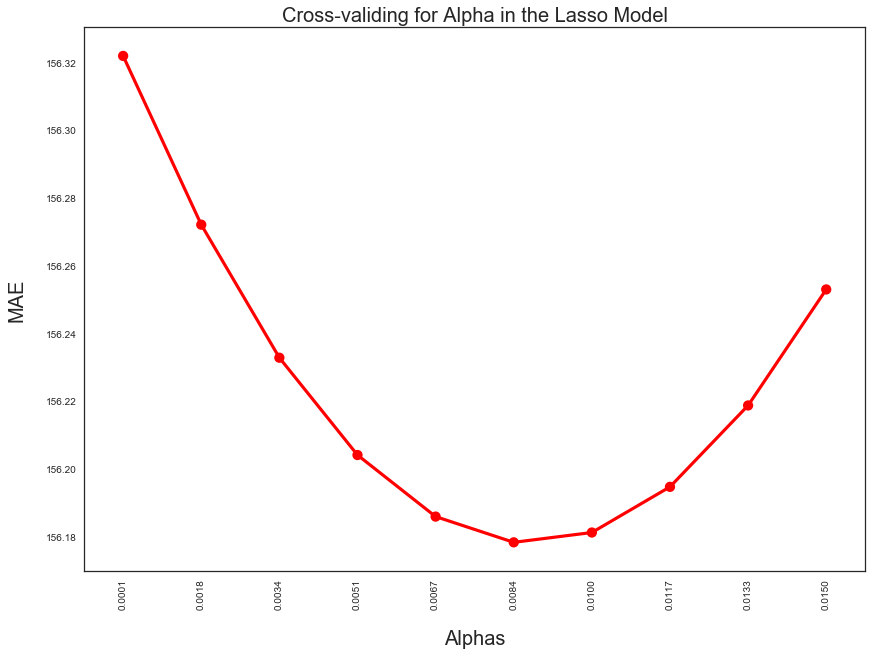

In [9]:
#Let's cross-validate for different alphas
alphas = np.linspace(0.0001, 0.015, 10)

mse_alphas = []

for a in alphas:
    model_lasso = Lasso(alpha = a, fit_intercept=False, max_iter = 2000)
    mse_alphas.append(model_cv(model_lasso, X_train_scaled, y_train_sqrt))
    
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
sns.pointplot(alphas, mse_alphas, color = 'red', alpha =0.5)
ax.set_ylabel('MAE', fontsize=20, labelpad =20)
ax.set_xlabel('Alphas', fontsize=20, labelpad = 20)
plt.title("Cross-validing for Alpha in the Lasso Model", fontsize=20)
plt.xticks(rotation='vertical')

xlabels = [format(label, '.4f') for label in alphas]
ax.set_xticklabels(xlabels)

In [10]:
index_min_alpha = mse_alphas.index(np.min(mse_alphas))

best_alpha = alphas[index_min_alpha]

In [11]:
#Training the model
model = Lasso(alpha = best_alpha).fit(X_train_scaled, y_train_sqrt)
y_pred_lasso = (model.predict(X_val_scaled))**2
print 'The MSE tuned Lasso is {0: ,}'.format(mean_squared_error(val_y, y_pred_lasso))
print 'The MAE tuned Lasso is {0: ,}'.format(mean_absolute_error(val_y, y_pred_lasso))

The MSE tuned Lasso is  1,551,418.96863
The MAE tuned Lasso is  876.299326771


In [12]:
#Looking at the coefficienct
coeff = pd.DataFrame(np.dstack((model.coef_, X_train_scaled.columns))[0]).set_index(1).rename(columns = {0: 'Coeff'})
eliminated_coeff = coeff.Coeff == 0
print coeff[eliminated_coeff].index

Index([u'store_31', u'store_78', u'store_123', u'store_148'], dtype='object', name=1)


The coefficient that were driven to zero are primarily store_ids! There must be a better feature to factor in the store id.  
  
That would require a bit more exploration than this sprint allows.

Let's plot the most important features from the current selection and their magnitude.

In [13]:
coeff['abs'] = np.absolute(coeff.Coeff)
top15 = coeff.sort_values('abs', ascending = False).iloc[:12].reset_index()

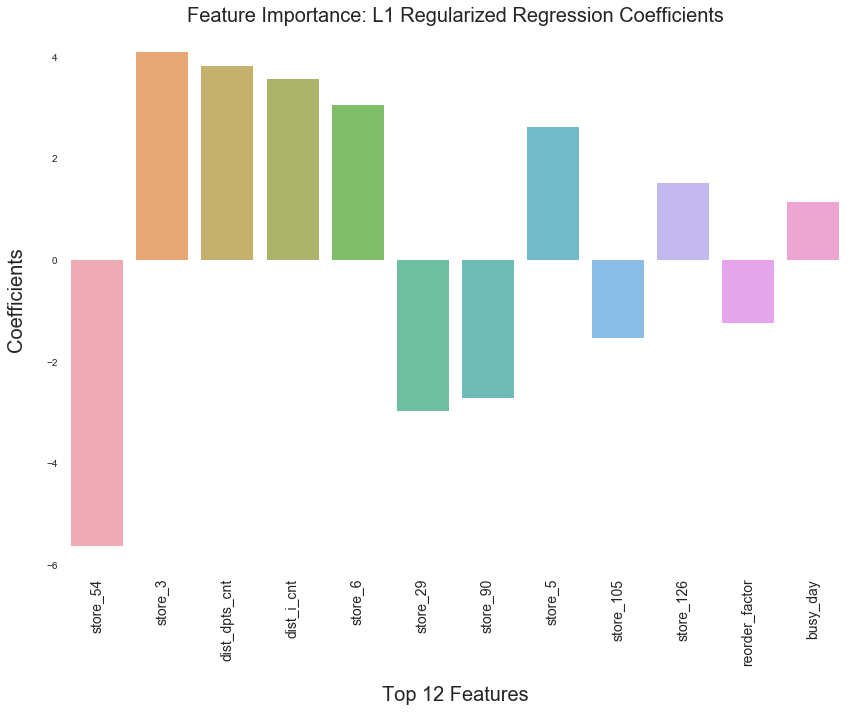

In [14]:
fig = plt.figure(figsize=(14,10))
ax_ = fig.add_subplot(111)
sns.barplot(x = 1, y = 'Coeff', data = top15, alpha=0.8, ax = ax_)
ax_.set_ylabel('Coefficients', fontsize=20, labelpad=20)
ax_.set_xlabel('Top 12 Features', fontsize=20, labelpad=20)
plt.title('Feature Importance: L1 Regularized Regression Coefficients', fontsize = 20)
for tick in ax_.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
                tick.label.set_rotation('vertical')
sns.despine(left=True, bottom=True)

### Random Forest

In [15]:
#Out of the box RF
rf = RandomForestRegressor(n_estimators = 100, max_features = 'sqrt')

#Train - predict 
rf.fit(X_train_scaled, y_train_sqrt)
y_pred_rf = rf.predict(X_val_scaled)

print 'MAE for an outofbox RandomForest is: {0:}'.format(mean_absolute_error(val_y, y_pred_rf **2))
print 'MSE for an outofbox RandomForest is: {0:}'.format(mean_squared_error(val_y, y_pred_rf **2))

MAE for an outofbox RandomForest is: 846.766252213
MSE for an outofbox RandomForest is: 1429190.93072


So after all the work on the Lasso, it turns out a Random Forest outperforms in terms of bias. 
  
Still, each has it's advantages.

Depending on our goal for this model, these are some considerations to take into account going forward from here.

#### Lasso

Advantages over Tree-based Model:
- Since it is a linear model, we can provide measurable insight on how our features influence shopping duration, providng extra value for teams within Instacart to guide optimizations.
- It is not parallizable yet it doesn't require great computational challenges.
- This model could be updated online as more data becomes available using stochastic gradient descent, instead of batch processing.

Considerations:
- As we saw from plotting and the MSE, there are high infulential points to be addressed before fitting the model. - We should explore increasing the complexity of this model, while cross-validating to avoid overfitting. Ideas would be to create cross-effects between our continous variables and some variable transformations (squared, cubed).

#### Random Forest:

Advantages over Lasso:  
  
- Can be parallelized so fitting larger sized datasets is not a problem
- Fast predections once it has been trained

Considerations: 
- We can take a look at a relative metric of feature importance to gauge their importance agains shopping duration. Still it is not as interpretable as the Lasso counterpart. 
- Needs to be tuned. Naturally we could increase the number of estimators and vary the number of maximum random features per split. I would use cross-validation to pick on the parameters that decrease the error metric.
- We could try a boosted variation of the tree-based model.

In any case, I would spent more time developing the feature space -- since better features typically beat better models.

### Predictions on the test set.

In [16]:
from os import path, listdir
#Get file names
files = [path.join('../data/', file) for file in sorted(listdir('../data/')) if file.endswith('csv')]

In [17]:
print files

['../data/order_items.csv', '../data/test_trips.csv', '../data/train_trips.csv']


In [18]:
#Read to dataframes
df_order_items = pd.read_csv(files[0])
df_test_trips = pd.read_csv(files[1])
df_train_trips = pd.read_csv(files[2])

In [19]:
#Separate for Preprocess consumption
train_order = df_order_items.loc[df_order_items.trip_id.isin(df_train_trips.trip_id)]
train_trips = df_train_trips.loc[df_train_trips.trip_id.isin(df_train_trips.trip_id)]

test_order = df_order_items.loc[df_order_items.trip_id.isin(df_test_trips.trip_id)]
test_trips = df_test_trips.loc[df_test_trips.trip_id.isin(df_test_trips.trip_id)]

In [20]:
#Init preprocessing class.
data = Preprocess(train_order, train_trips, test_order, test_trips)
#Fit
data.fit()
#Get data either scaled
X_train_scaled, X_test_scaled, test_ids, y_train_sqrt = data.get_data(scale = True)

In [29]:
#Training
model = Lasso(alpha = best_alpha).fit(X_train_scaled, y_train_sqrt)
#Prediction
y_pred_lasso = (model.predict(X_test_scaled))**2

In [44]:
#Formating for challenge rules
test_ids = test_ids.to_frame()
test_ids['y_pred'] = y_pred_lasso
test_ids = test_ids.rename(columns={'y_pred': 'shopping_time'})
test_ids.set_index('trip_id', inplace=True)

In [48]:
#Export as csv
test_ids.to_csv('sample.csv')

In [49]:
test_ids.head(10)

,shopping_time
trip_id,
4310899,2445.294187
4310904,4006.600407
4310907,2335.957549
4310911,1533.182710
4310328,2340.402845
4310306,2392.768218
4311006,1279.926549
4310319,2079.672576
4311215,1675.479302
